In [1]:
# Load "autoreload" extension so that code can change; set it so modules are reloaded before execution
%load_ext autoreload
%autoreload 2

In [2]:
import os
import os.path as op

import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import e as CHARGE
from scipy.constants import h as PLANK
from scipy.optimize import curve_fit, lsq_linear
from uncertainties import ufloat

from wien2k_parse.core import Wien2kParse as w2k

GAMMA = 4.596163e7/(2*np.pi) # Hz/T
QUADMOM = 0.314e-28 # m^2

In [4]:
case = 'BaFe2As2'
head_dir = op.abspath('../data/raw/BaFe2As2_Co_doped')
efg_site = 'As1'
magmom_site = 'Fe1'

efg_data = {}
magmom_data = {}
for pCo in ['0.00o', '0.00t', '0.02', '0.045']:
    perc_dirs = next(os.walk(op.join(head_dir, pCo, 'mreduce')))[1]
    non_error_percs = []
    for i, perc in enumerate(perc_dirs):
        data_dir = op.join(head_dir, pCo, 'mreduce', perc, case)
        try:
            wien = w2k(data_dir)
        except ValueError:
            continue
        non_error_percs.append(perc)
    n = len(non_error_percs)
    efg_data[pCo] = np.zeros((n, 4))
    magmom_data[pCo] = np.zeros(n)
    for i, perc in enumerate(non_error_percs):
        data_dir = op.join(head_dir, pCo, 'mreduce', perc, case)
        wien = w2k(data_dir)
        efg = wien.efg(efg_site)[efg_site].gac_tensor
        magmom_data[pCo][i] = wien.magmom[magmom_site]
        eta = (efg[0, 0] - efg[2, 2])/efg[1, 1]
        efg_data[pCo][i, :] = np.array([[efg[0, 0], efg[2, 2], efg[1, 1], eta]])
        
# pCo = '0.0'
# perc_dirs = next(os.walk(op.join(head_dir, pCo, 'mreduce')))[1]
# efg_data[pCo] = np.empty((1, 4))
# magmom_data[pCo] = np.array([])
# for i, perc in enumerate(perc_dirs):
#     data_dir = op.join(head_dir, pCo, 'mreduce', perc, case)
#     wien = w2k(data_dir)
#     efg = wien.efg(efg_site)[efg_site].gac_tensor
#     magmom_data[pCo] = np.append(magmom_data[pCo], wien.magmom[magmom_site])
#     eta = (efg[0, 0] - efg[2, 2])/efg[1, 1]
#     efg_data[pCo] = np.append(efg_data[pCo], np.array([[efg[0, 0], efg[2, 2], efg[1, 1], eta]]), axis=0)

In [5]:
# (temperature, Co concentration, measurement)
NUC_EXP = [(10, 0.0, ufloat(2.22, 0.03)),
           (144, 0.0, ufloat(2.3855182247571514, 0.04)),
           (109, 0.02, ufloat(2.334676053827646, 0.04)),
           (78, 0.05, ufloat(2.2840923268870874, 0.04))]
ETA_EXP = [(10, 0.0, ufloat(1.18, 0.06)),
           (144, 0.0, ufloat(0.03326091019530891, 0.004)),
           (109, 0.02, ufloat(0.07355776718686724, 0.004)),
           (78, 0.05, ufloat(0.10134021742516272, 0.004))]
MAGMOM_EXP = [(10, 0.0, ufloat(0.87, 0.03)),
              (20, 0.02, ufloat(0.7546790528291857, 0.09)),# Actually x = 0.0187
              (20, 0.05, ufloat(0.4474092992901858, 0.09))]# Actually x = 0.045

[ 0.55832352  0.35952146 -0.05138569] [ 0.37692628 -0.34504941 -0.08447173] [-0.93524851 -0.01447212  0.13585714] [0.22322341 0.28915473 0.66221806]
[ 0.52070058  0.37894562 -0.05179214] [ 0.51873379 -0.38186627 -0.0720672 ] [-1.03943466  0.00291963  0.12385955] [0.02564898 0.35278095 0.51474087]
[ 0.52531936  0.35423993 -0.04465095] [ 0.53578392 -0.37440378 -0.06969465] [-1.06110172  0.02016582  0.11434454] [0.01211049 0.3933483  0.39948945]
[ 0.51370372  0.33621946 -0.03973923] [ 0.51331991 -0.32044061 -0.078563  ] [-1.02702224 -0.01578131  0.11830304] [0.00897591 0.45000681 0.27618016]


(0.0, 0.55)

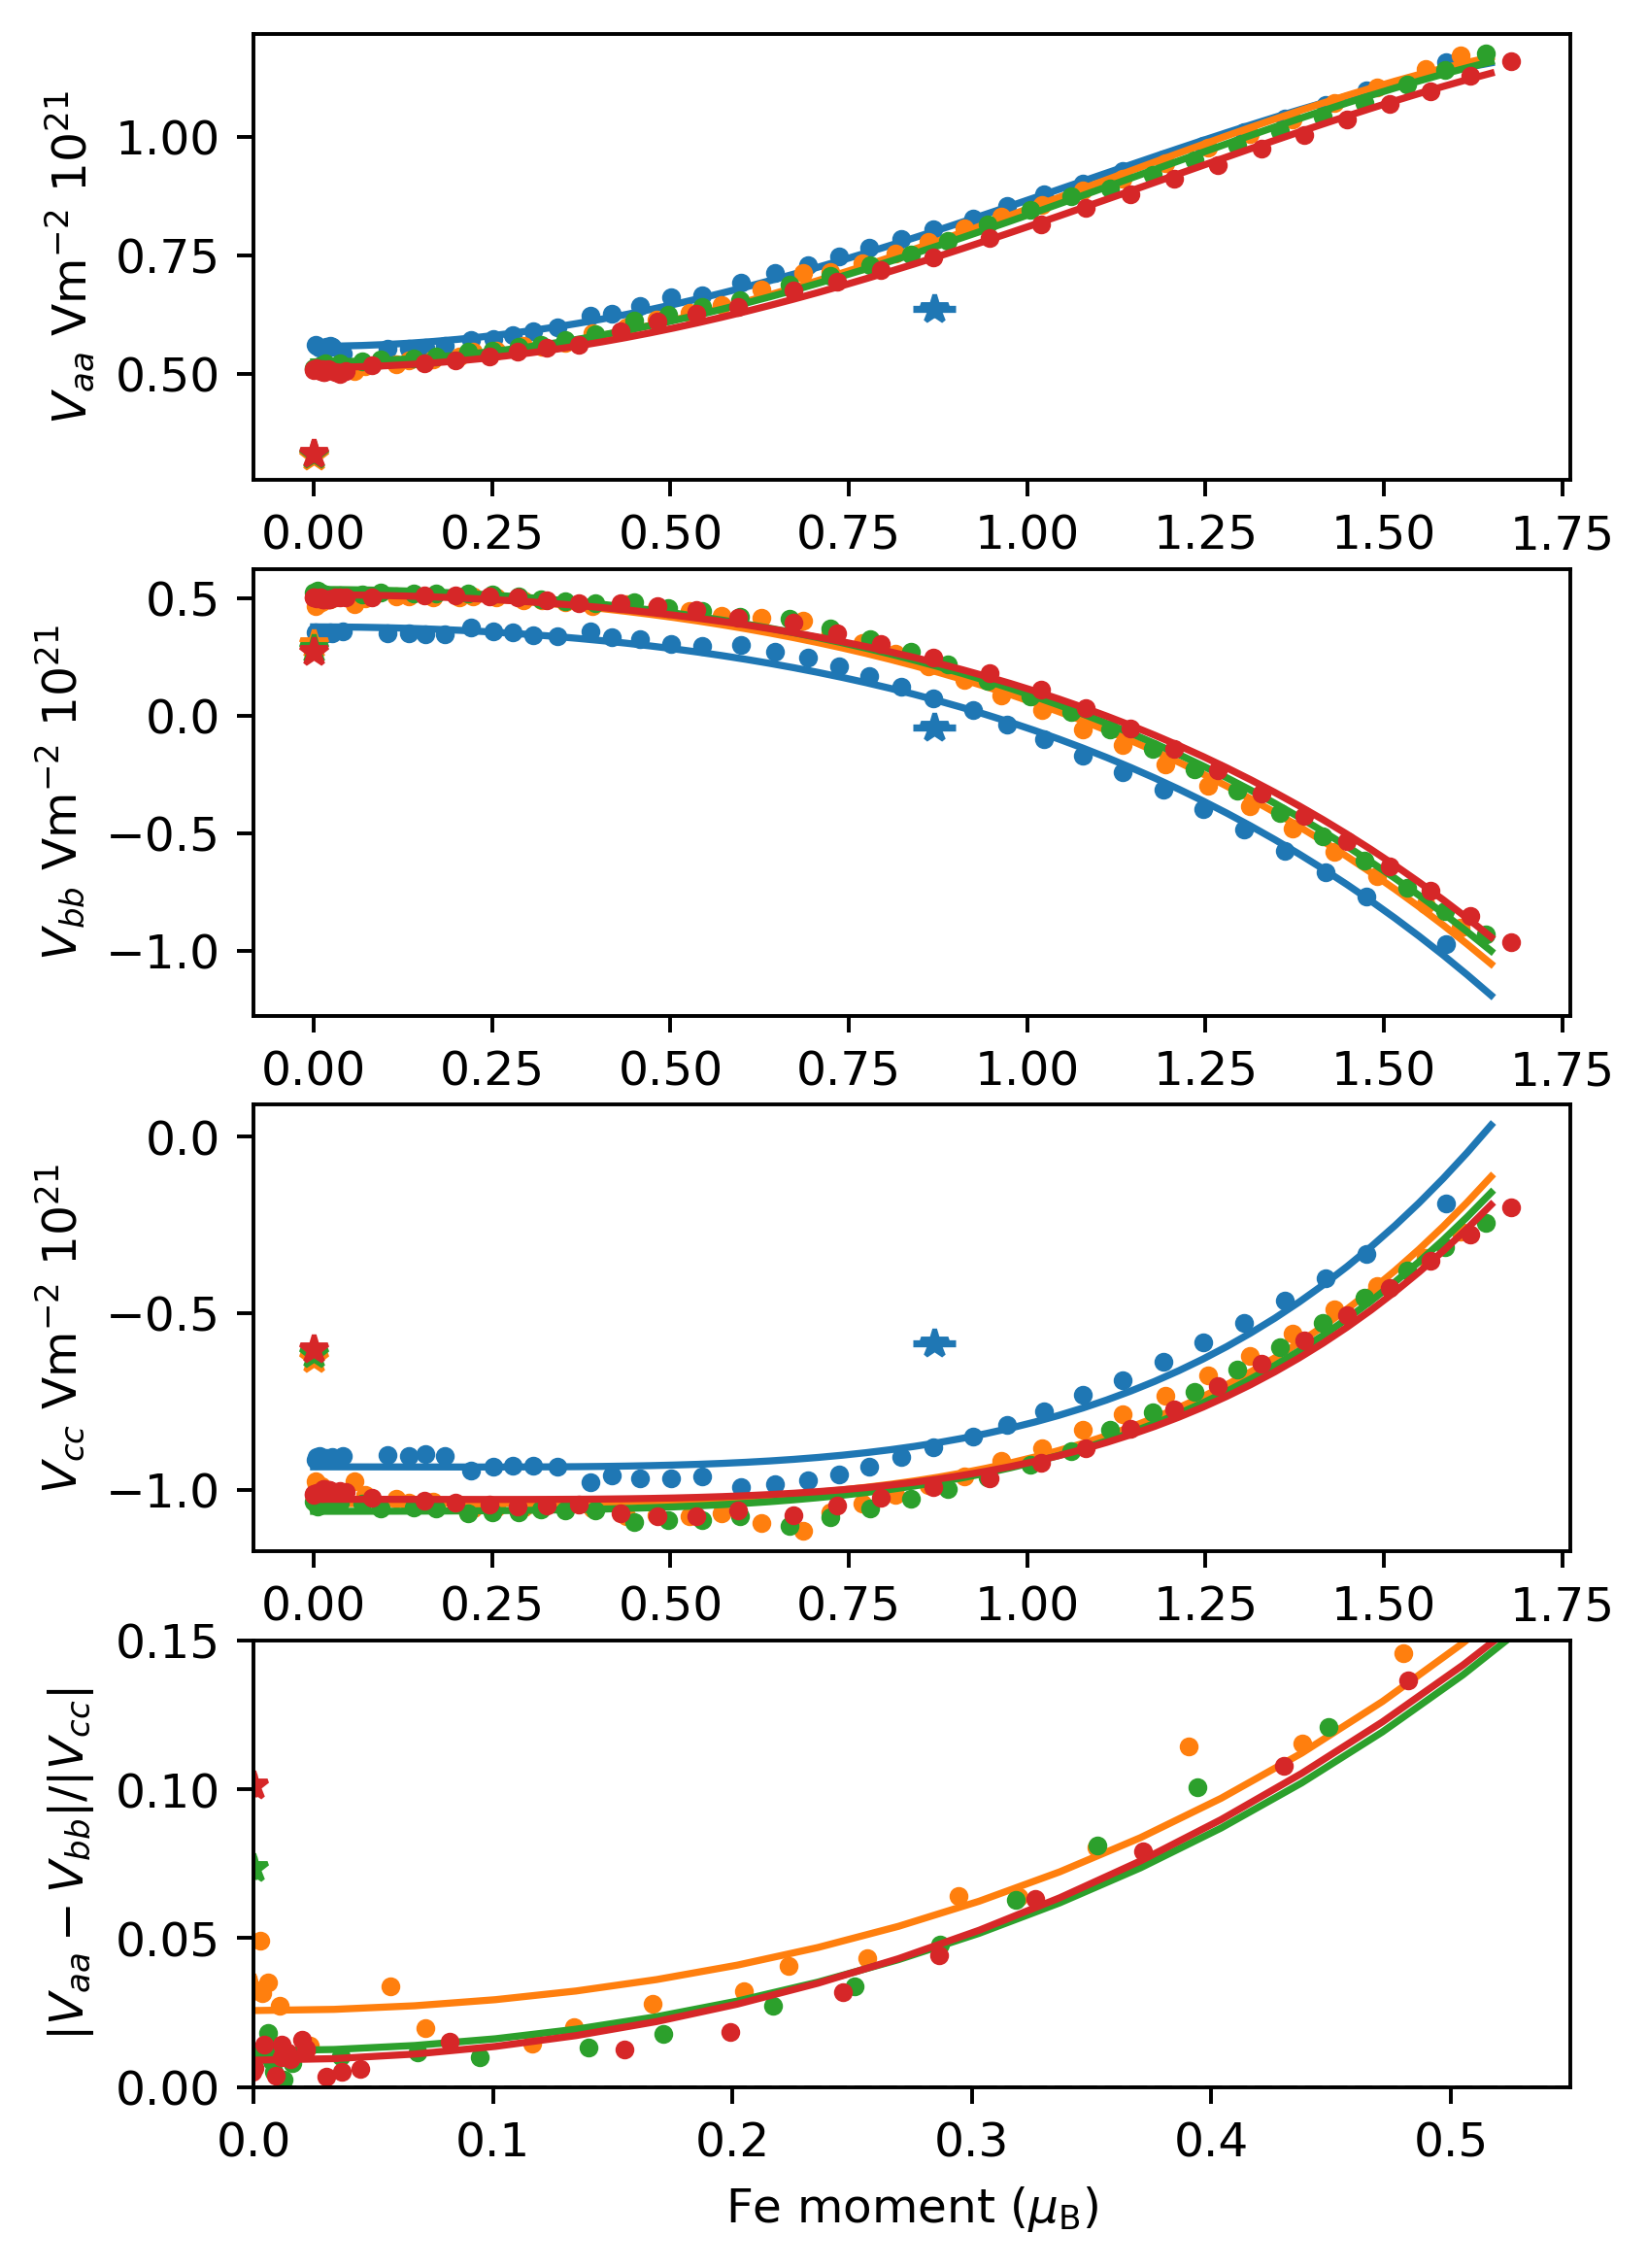

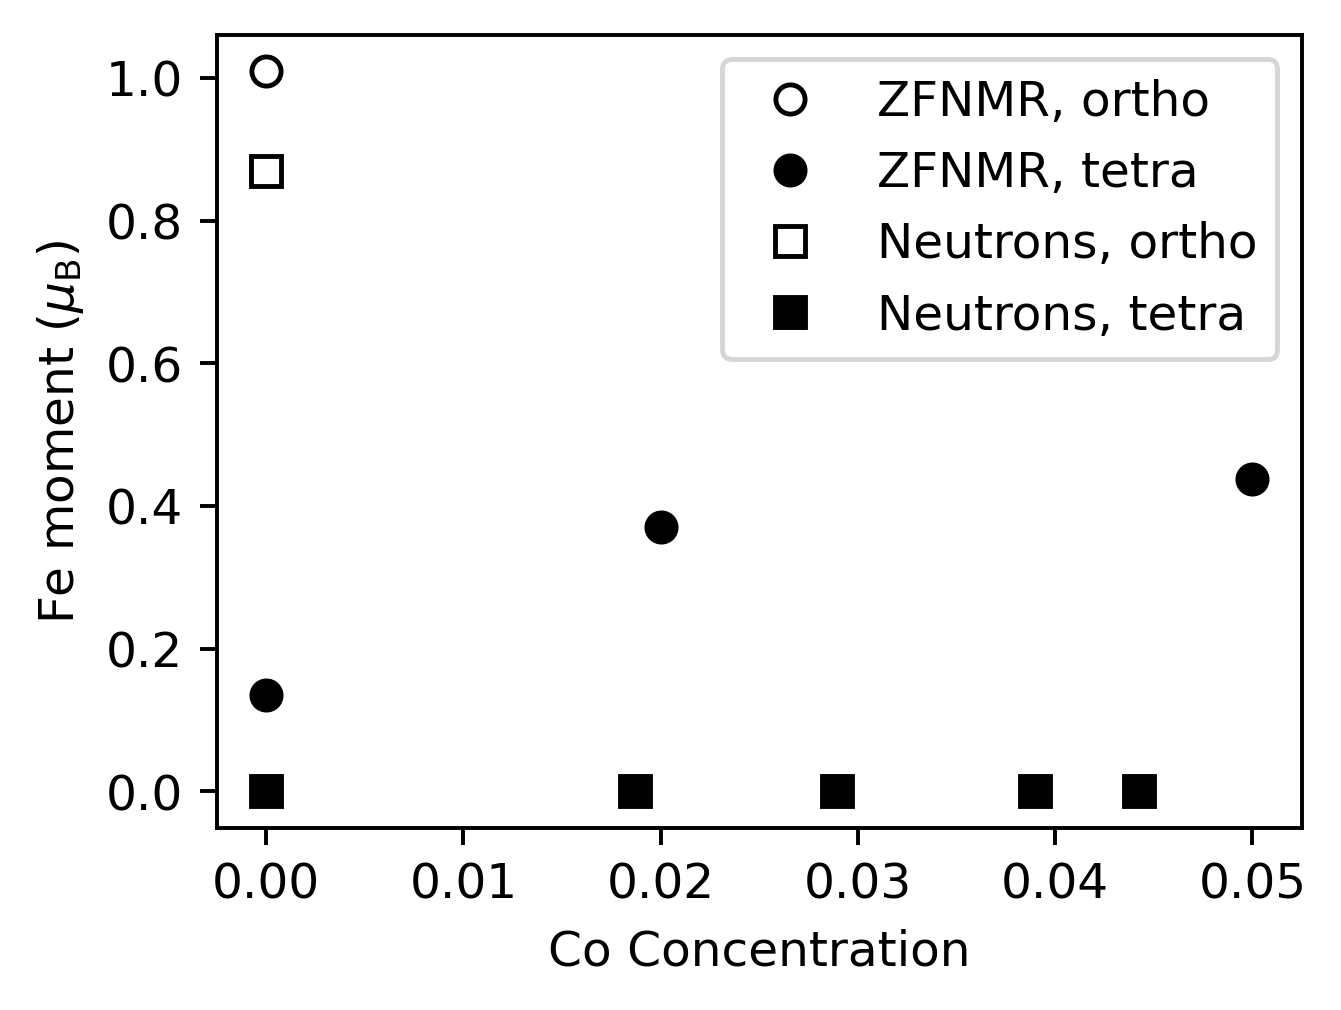

In [32]:
def make_label(label):
    return f'{np.float64(label)*100}% Co'

def get_efg(nuc, eta):
    Vcc = 2*PLANK*nuc*1e6/(CHARGE*QUADMOM)
    Vaa = -Vcc/2*(1 + eta)
    Vbb = Vcc/2*(-1 + eta)
    
    return Vaa, Vbb, Vcc

def model(x, a, b, c):
    #result = a*np.power(x - b, 2) + d
    result = a*x**2 + b*x**4 + c
        
    return result

fig, axs = plt.subplots(4, dpi=350, figsize=(5, 8))
figmm, axmm = plt.subplots(1, dpi=350, figsize=(4, 3))
pCos = ['0.00o', '0.00t', '0.02', '0.045']
labels = {'0.00o': '0.0% Co ortho',
          '0.00t': '0.0% Co tetra',
          '0.02': '2.0% Co',
          '0.045': '4.5% Co'}
stops = {'0.00o': -10, '0.00t': -10, '0.02':-9, '0.045': -8}
dft_lines = []
exp_lines = []
eta_data = []
for pCo in pCos:
    order = np.argsort(magmom_data[pCo])
    magmom = magmom_data[pCo][order]
    Vaa = efg_data[pCo][:, 0][order]/1e21
    Vbb = efg_data[pCo][:, 1][order]/1e21
    Vcc = efg_data[pCo][:, 2][order]/1e21
    eta = np.abs(Vaa - Vbb)/np.abs(Vcc)#efg_data[pCo][:, 3][order]
    stop = stops[pCo]
    line, = axs[0].plot(magmom[1:stop], Vaa[1:stop], '.', label=labels[pCo])
    axs[1].plot(magmom[1:stop], Vbb[1:stop], '.', label=labels[pCo])
    axs[2].plot(magmom[1:stop], Vcc[1:stop], '.', label=labels[pCo])
    axs[3].plot(magmom[1:stop], eta[1:stop], '.', label=labels[pCo])
    n = magmom[1:stop].size
    A = np.zeros((n, 3))
    A[:, 0] = 1
    A[:, 1] = magmom[1:stop]**2
    A[:, 2] = magmom[1:stop]**4
    ao = lsq_linear(A, Vaa[1:stop])
    bo = lsq_linear(A, Vbb[1:stop])
    co = lsq_linear(A, Vcc[1:stop])
    etao = lsq_linear(A[:-10, :], eta[1:stop-10])
    print(ao.x, bo.x, co.x, etao.x)
    xs = np.linspace(0, 1.65)
    fita = ao.x[0] + ao.x[1]*xs**2 + ao.x[2]*xs**4
    fitb = bo.x[0] + bo.x[1]*xs**2 + bo.x[2]*xs**4
    fitc = co.x[0] + co.x[1]*xs**2 + co.x[2]*xs**4
    fiteta = etao.x[0] + etao.x[1]*xs**2 + etao.x[2]*xs**4
    #fiteta = np.abs(fita - fitb)/np.abs(fitc)
    axs[0].plot(xs, fita, c=line.get_color())
    axs[1].plot(xs, fitb, c=line.get_color())
    axs[2].plot(xs, fitc, c=line.get_color())
    axs[3].plot(xs, fiteta, c=line.get_color())
    dft_lines.append(line)
    eta_data.append(fiteta)
    
labels = {'0.00o': '0.0% Co ortho',
          '0.00t': '0.0% Co tetra',
          '0.02': '2.0% Co',
          '0.05': '5.0% Co'}

exp = {'0.00o': get_efg(NUC_EXP[0][2], ETA_EXP[0][2]) + (0.87, ),
       '0.00t': get_efg(NUC_EXP[1][2], ETA_EXP[1][2]) + (0, ),     
       '0.02': get_efg(NUC_EXP[2][2], ETA_EXP[2][2]) + (0, ),
       '0.05': get_efg(NUC_EXP[3][2], ETA_EXP[3][2]) + (0, )
      }
eff_magmom = {}

pCo='0.00o'
m = '*'
c = dft_lines[0].get_color()
magmom = exp[pCo][-1]
Vaa, Vbb, Vcc = exp[pCo][0:-1]
eta = np.abs(Vaa - Vbb)/np.abs(Vcc)
line = axs[0].errorbar(magmom, -Vaa.n/1e21, fmt=m, color=c, xerr=0.03, yerr=Vaa.s/1e21, label=labels[pCo])
axs[1].errorbar(magmom, -Vbb.n/1e21, fmt=m, color=c, xerr=0.03, yerr=Vbb.s/1e21)
axs[2].errorbar(magmom, -Vcc.n/1e21, fmt=m, color=c, xerr=0.03, yerr=Vcc.s/1e21)
axs[3].errorbar(magmom, eta.n, fmt=m, color=c, xerr=0.03, yerr=eta.s)
exp_lines.append(line)
axmm.plot(0.00, xs[np.abs(eta_data[0] - eta.n).argmin()], 'o', fillstyle='none', c='k', label='ZFNMR, ortho')

pCo='0.00t'
m = '*'
c = dft_lines[1].get_color()
magmom = exp[pCo][-1]
Vaa, Vbb, Vcc = exp[pCo][0:-1]
eta = np.abs(Vaa - Vbb)/np.abs(Vcc)
line = axs[0].errorbar(magmom, -Vaa.n/1e21, fmt=m, color=c, yerr=Vaa.s/1e21, label=labels[pCo])
axs[1].errorbar(magmom, -Vbb.n/1e21, fmt=m, color=c, yerr=Vbb.s/1e21)
axs[2].errorbar(magmom, -Vcc.n/1e21, fmt=m, color=c, yerr=Vcc.s/1e21)
axs[3].errorbar(magmom, eta.n, fmt=m, color=c, yerr=eta.s)
exp_lines.append(line)
#axs[3].axhline(eta.n, c=c, ls='--', lw=1)
axmm.plot(0.00, xs[np.abs(eta_data[1] - eta.n).argmin()], 'o', c='k', label='ZFNMR, tetra')


pCo='0.02'
m = '*'
c = dft_lines[2].get_color()
magmom = exp[pCo][-1]
Vaa, Vbb, Vcc = exp[pCo][0:-1]
eta = np.abs(Vaa - Vbb)/np.abs(Vcc)
line = axs[0].errorbar(magmom, -Vaa.n/1e21, fmt=m, color=c, yerr=Vaa.s/1e21, label=labels[pCo])
axs[1].errorbar(magmom, -Vbb.n/1e21, fmt=m, color=c, yerr=Vbb.s/1e21)
axs[2].errorbar(magmom, -Vcc.n/1e21, fmt=m, color=c, yerr=Vcc.s/1e21)
axs[3].errorbar(magmom, eta.n, fmt=m, color=c, yerr=eta.s)
exp_lines.append(line)
#axs[3].axhline(eta.n, c=c, ls='--', lw=1)
axmm.plot(0.02, xs[np.abs(eta_data[2] - eta.n).argmin()], 'o', c='k')


pCo='0.05'
m = '*'
c = dft_lines[3].get_color()
magmom = exp[pCo][-1]
Vaa, Vbb, Vcc = exp[pCo][0:-1]
eta = np.abs(Vaa - Vbb)/np.abs(Vcc)
line = axs[0].errorbar(magmom, -Vaa.n/1e21, fmt=m, color=c, yerr=Vaa.s/1e21, label=labels[pCo])
axs[1].errorbar(magmom, -Vbb.n/1e21, fmt=m, color=c, yerr=Vbb.s/1e21)
axs[2].errorbar(magmom, -Vcc.n/1e21, fmt=m, color=c, yerr=Vcc.s/1e21)
axs[3].errorbar(magmom, eta.n, fmt=m, color=c, yerr=eta.s)
exp_lines.append(line)
#axs[3].axhline(eta.n, c=c, ls='--', lw=1)
axmm.plot(0.05, xs[np.abs(eta_data[3] - eta.n).argmin()], 'o', c='k')

# neutrons_mm = np.array([[0, 0.87],
#                         [0.01871806440697084, 0.7546790528291857],
#                         [0.028946075074325034, 0.6098181554500997],
#                         [0.03899151606951505, 0.5736691992233136],
#                         [0.04424172353505161, 0.4474092992901858]])
neutrons_mm = np.array([[0, 0.87],
                        [0, 0],
                        [0.01871806440697084, 0.],
                        [0.028946075074325034, 0.],
                        [0.03899151606951505, 0.],
                        [0.04424172353505161, 0.]])
axmm.plot(neutrons_mm[0, 0], neutrons_mm[0, 1], 's', fillstyle='none', c='k', label='Neutrons, ortho')
axmm.plot(neutrons_mm[1:, 0], neutrons_mm[1:, 1], 's', fillstyle='full', c='k', label='Neutrons, tetra')
axmm.set_xlabel('Co Concentration')
axmm.set_ylabel(r'Fe moment ($ \mu_\mathrm{B} $)')

axmm.legend()

axs[0].set_ylabel(r'$ V_{aa}$ Vm$^{-2}$ 10$^{21}$')
axs[1].set_ylabel(r'$ V_{bb}$ Vm$^{-2}$ 10$^{21}$')
axs[2].set_ylabel(r'$ V_{cc}$ Vm$^{-2}$ 10$^{21}$')
axs[3].set_ylabel(r'$ |V_{aa} - V_{bb}|/|V_{cc}| $')
axs[3].set_xlabel(r'Fe moment ($ \mu_\mathrm{B} $)')

axs[3].axhline(0, c='k', ls='--', lw=1)

axs[3].set_ylim(0, 0.15)
axs[3].set_xlim(0, 0.55)

# axs[1].legend(handles=dft_lines, title='DFT', loc='lower center')
# axs[0].legend(handles=exp_lines, title='Experiment')
# fig.legend(handles=dft_lines, title='DFT', loc='center right')
# fig.legend(handles=exp_lines, title='Experiment')

#axs[0].legend()
# print(exp['0.00'])

In [ ]:
def make_label(label):
    return f'{np.float64(label)*100}% Co'

def get_efg(nuc, eta):
    Vcc = 2*PLANK*nuc*1e6/(CHARGE*QUADMOM)
    Vaa = -Vcc/2*(1 + eta)
    Vbb = Vcc/2*(-1 + eta)
    
    return Vaa, Vbb, Vcc

def model(x, a, b, c):
    #result = a*np.power(x - b, 2) + d
    result = a*x**2 + b*x**4 + c
    
#     print('a=', a)
#     print('b=', b)
#     print('c=', c)
#     print('d=', d)
#     print('x=', x)
#     print('x-b= ', x - b)
#     print('(x-b)^c= ', np.power(x - b, c))
#     print('a(x-b)^c= ', a*np.power(x - b, c))
#     print('result= ', result)
#     print('======\n')
        
    return result

fig, axs = plt.subplots(4, dpi=350, figsize=(5, 8))
figmm, axmm = plt.subplots(1, dpi=350, figsize=(4, 3))
pCos = ['0.00o', '0.00t', '0.02', '0.045']
labels = {'0.00o': '0.0% Co ortho',
          '0.00t': '0.0% Co tetra',
          '0.02': '2.0% Co',
          '0.045': '4.5% Co'}
stops = {'0.00o': -10, '0.00t': -10, '0.02':-9, '0.045': -8}
dft_lines = []
exp_lines = []
eta_data = []
for pCo in pCos:
    order = np.argsort(magmom_data[pCo])
    magmom = magmom_data[pCo][order]
    Vaa = efg_data[pCo][:, 0][order]/1e21
    Vbb = efg_data[pCo][:, 1][order]/1e21
    Vcc = efg_data[pCo][:, 2][order]/1e21
    eta = np.abs(Vaa - Vbb)/np.abs(Vcc)#efg_data[pCo][:, 3][order]
    stop = stops[pCo]
    line, = axs[0].plot(magmom[1:stop], Vaa[1:stop], '.', label=labels[pCo])
    axs[1].plot(magmom[1:stop], Vbb[1:stop], '.', label=labels[pCo])
    axs[2].plot(magmom[1:stop], Vcc[1:stop], '.', label=labels[pCo])
    axs[3].plot(magmom[1:stop], eta[1:stop], '.', label=labels[pCo])
    poptaa = curve_fit(model, magmom[1:stop], Vaa[1:stop])#, p0=(0, 0, 0))
    poptbb = curve_fit(model, magmom[1:stop], Vbb[1:stop])#, p0=(0, 0, 0))
    poptcc = curve_fit(model, magmom[1:stop], Vcc[1:stop])#, p0=(0, 0, 0))
    popteta = curve_fit(model, magmom[1:stop], eta[1:stop])#, p0=(0, 0, 0))
    xs = np.linspace(0, 1.75)
    eta_fit = np.abs(model(xs, *poptaa[0]) - model(xs, *poptbb[0]))/np.abs(model(xs, *poptcc[0]))
    axs[0].plot(xs, model(xs, *poptaa[0]), c=line.get_color())
    axs[1].plot(xs, model(xs, *poptbb[0]), c=line.get_color())
    axs[2].plot(xs, model(xs, *poptcc[0]), c=line.get_color())
    #axs[3].plot(xs, model(xs, *popteta[0]), c=line.get_color())
    axs[3].plot(xs, eta_fit, c=line.get_color())
    dft_lines.append(line)
    eta_data.append(eta_fit)
    #print(magmom, poptaa[0])
    
# for i, exp in enumerate(EXP):
#     T, pCo, nuc, eta = exp
#     print(T, pCo, nuc, eta)
#     m = '*'
#     c = axs[0].lines[i].get_color()
#     magmom = 0
#     Vaa, Vbb, Vcc = get_efg(nuc, eta)
#     eta = np.abs(Vaa - Vbb)/np.abs(Vcc)
#     line = axs[0].errorbar(magmom, -Vaa.n/1e21, fmt=m, color=c, yerr=Vaa.s/1e21, label=make_label(pCo, ))
#     axs[1].errorbar(magmom, -Vbb.n/1e21, fmt=m, color=c, yerr=Vbb.s/1e21)
#     axs[2].errorbar(magmom, -Vcc.n/1e21, fmt=m, color=c, yerr=Vcc.s/1e21)
#     axs[3].errorbar(magmom, eta.n, fmt=m, color=c, yerr=eta.s)
#     exp_lines.append(line)

labels = {'0.00o': '0.0% Co ortho',
          '0.00t': '0.0% Co tetra',
          '0.02': '2.0% Co',
          '0.05': '5.0% Co'}

exp = {'0.00o': get_efg(NUC_EXP[0][2], ETA_EXP[0][2]) + (0.87, ),
       '0.00t': get_efg(NUC_EXP[1][2], ETA_EXP[1][2]) + (0, ),     
       '0.02': get_efg(NUC_EXP[2][2], ETA_EXP[2][2]) + (0, ),
       '0.05': get_efg(NUC_EXP[3][2], ETA_EXP[3][2]) + (0, )
      }
eff_magmom = {}

pCo='0.00o'
m = '*'
c = dft_lines[0].get_color()
magmom = exp[pCo][-1]
Vaa, Vbb, Vcc = exp[pCo][0:-1]
eta = np.abs(Vaa - Vbb)/np.abs(Vcc)
line = axs[0].errorbar(magmom, -Vaa.n/1e21, fmt=m, color=c, xerr=0.03, yerr=Vaa.s/1e21, label=labels[pCo])
axs[1].errorbar(magmom, -Vbb.n/1e21, fmt=m, color=c, xerr=0.03, yerr=Vbb.s/1e21)
axs[2].errorbar(magmom, -Vcc.n/1e21, fmt=m, color=c, xerr=0.03, yerr=Vcc.s/1e21)
axs[3].errorbar(magmom, eta.n, fmt=m, color=c, xerr=0.03, yerr=eta.s)
exp_lines.append(line)
axmm.plot(0.00, xs[np.abs(eta_data[0] - eta.n).argmin()], 'o', fillstyle='none', c='k', label='ZFNMR, ortho')

pCo='0.00t'
m = '*'
c = dft_lines[1].get_color()
magmom = exp[pCo][-1]
Vaa, Vbb, Vcc = exp[pCo][0:-1]
eta = np.abs(Vaa - Vbb)/np.abs(Vcc)
line = axs[0].errorbar(magmom, -Vaa.n/1e21, fmt=m, color=c, yerr=Vaa.s/1e21, label=labels[pCo])
axs[1].errorbar(magmom, -Vbb.n/1e21, fmt=m, color=c, yerr=Vbb.s/1e21)
axs[2].errorbar(magmom, -Vcc.n/1e21, fmt=m, color=c, yerr=Vcc.s/1e21)
axs[3].errorbar(magmom, eta.n, fmt=m, color=c, yerr=eta.s)
exp_lines.append(line)
#axs[3].axhline(eta.n, c=c, ls='--', lw=1)
axmm.plot(0.00, xs[np.abs(eta_data[1] - eta.n).argmin()], 'o', c='k', label='ZFNMR, tetra')


pCo='0.02'
m = '*'
c = dft_lines[2].get_color()
magmom = exp[pCo][-1]
Vaa, Vbb, Vcc = exp[pCo][0:-1]
eta = np.abs(Vaa - Vbb)/np.abs(Vcc)
line = axs[0].errorbar(magmom, -Vaa.n/1e21, fmt=m, color=c, yerr=Vaa.s/1e21, label=labels[pCo])
axs[1].errorbar(magmom, -Vbb.n/1e21, fmt=m, color=c, yerr=Vbb.s/1e21)
axs[2].errorbar(magmom, -Vcc.n/1e21, fmt=m, color=c, yerr=Vcc.s/1e21)
axs[3].errorbar(magmom, eta.n, fmt=m, color=c, yerr=eta.s)
exp_lines.append(line)
#axs[3].axhline(eta.n, c=c, ls='--', lw=1)
axmm.plot(0.02, xs[np.abs(eta_data[2] - eta.n).argmin()], 'o', c='k')


pCo='0.05'
m = '*'
c = dft_lines[3].get_color()
magmom = exp[pCo][-1]
Vaa, Vbb, Vcc = exp[pCo][0:-1]
eta = np.abs(Vaa - Vbb)/np.abs(Vcc)
line = axs[0].errorbar(magmom, -Vaa.n/1e21, fmt=m, color=c, yerr=Vaa.s/1e21, label=labels[pCo])
axs[1].errorbar(magmom, -Vbb.n/1e21, fmt=m, color=c, yerr=Vbb.s/1e21)
axs[2].errorbar(magmom, -Vcc.n/1e21, fmt=m, color=c, yerr=Vcc.s/1e21)
axs[3].errorbar(magmom, eta.n, fmt=m, color=c, yerr=eta.s)
#axs[3].axhline(eta.n, c=c, ls='--', lw=1)
axmm.plot(0.05, xs[np.abs(eta_data[3] - eta.n).argmin()], 'o', c='k')

# neutrons_mm = np.array([[0, 0.87],
#                         [0.01871806440697084, 0.7546790528291857],
#                         [0.028946075074325034, 0.6098181554500997],
#                         [0.03899151606951505, 0.5736691992233136],
#                         [0.04424172353505161, 0.4474092992901858]])
neutrons_mm = np.array([[0, 0.87],
                        [0, 0],
                        [0.01871806440697084, 0.],
                        [0.028946075074325034, 0.],
                        [0.03899151606951505, 0.],
                        [0.04424172353505161, 0.]])
axmm.plot(neutrons_mm[0, 0], neutrons_mm[0, 1], 's', fillstyle='none', c='k', label='Neutrons, ortho')
axmm.plot(neutrons_mm[1:, 0], neutrons_mm[1:, 1], 's', fillstyle='full', c='k', label='Neutrons, tetra')
axmm.set_xlabel('Co Concentration')
axmm.set_ylabel(r'Fe moment ($ \mu_\mathrm{B} $)')

axmm.legend()

exp_lines.append(line)

axs[0].set_ylabel(r'$ V_{aa}$ Vm$^{-2}$ 10$^{21}$')
axs[1].set_ylabel(r'$ V_{bb}$ Vm$^{-2}$ 10$^{21}$')
axs[2].set_ylabel(r'$ V_{cc}$ Vm$^{-2}$ 10$^{21}$')
axs[3].set_ylabel(r'$ |V_{aa} - V_{bb}|/|V_{cc}| $')
axs[3].set_xlabel(r'Fe moment ($ \mu_\mathrm{B} $)')

axs[3].axhline(0, c='k', ls='--', lw=1)

axs[3].set_ylim(0, 0.15)
axs[3].set_xlim(0, 0.55)

axs[1].legend(handles=dft_lines, title='DFT', loc='lower center')
axs[0].legend(handles=exp_lines, title='Experiment')

#axs[0].legend()
# print(exp['0.00'])

In [ ]:
### OLD ###

# def make_label(label):
#     return f'{np.float64(label)*100}% Co'

# def get_efg(nuc, eta):
#     Vcc = 2*PLANK*nuc*1e6/(CHARGE*QUADMOM)
#     Vaa = -Vcc/2*(1 + eta)
#     Vbb = Vcc/2*(-1 + eta)
    
#     return Vaa, Vbb, Vcc

# fig, axs = plt.subplots(4, dpi=350, figsize=(5, 8))
# pCos = ['0.0', '0.047', '0.054']
# stops = {'0.0': -15, '0.047':-3, '0.054': -3}
# dft_lines = []
# exp_lines = []
# for pCo in pCos:
#     order = np.argsort(magmom_data[pCo])
#     magmom = magmom_data[pCo][order]
#     Vaa = efg_data[pCo][:, 0][order]/1e21
#     Vbb = efg_data[pCo][:, 1][order]/1e21
#     Vcc = efg_data[pCo][:, 2][order]/1e21
#     eta = np.abs(Vaa - Vbb)/np.abs(Vcc)#efg_data[pCo][:, 3][order]
#     stop = stops[pCo]
#     line, = axs[0].plot(magmom[1:stop], Vaa[1:stop], '.-', label=make_label(pCo))
#     axs[1].plot(magmom[1:stop], Vbb[1:stop], '.-', label=make_label(pCo))
#     axs[2].plot(magmom[1:stop], Vcc[1:stop], '.-', label=make_label(pCo))
#     axs[3].plot(magmom[1:stop], eta[1:stop], '.-', label=make_label(pCo))
#     dft_lines.append(line)
    
# exp = {'0.0': get_efg(NUC_EXP['0.0'], ETA_EXP['0.0']) + (MAGMOM_EXP['0.0'], ),
#        '0.05': get_efg(NUC_EXP['0.05'], ETA_EXP['0.05']) + (MAGMOM_EXP['0.05'], )
#       }
# pCo='0.0'
# m = 's'
# c = axs[0].lines[0].get_color()
# magmom = exp[pCo][-1]
# Vaa, Vbb, Vcc = exp[pCo][0:-1]
# eta = np.abs(Vaa - Vbb)/np.abs(Vcc)
# line = axs[0].errorbar(magmom.n, -Vaa.n/1e21, fmt=m, color=c, xerr=magmom.s, yerr=Vaa.s/1e21, label=make_label(pCo))
# axs[1].errorbar(magmom.n, -Vbb.n/1e21, fmt=m, color=c, xerr=magmom.s, yerr=Vbb.s/1e21)
# axs[2].errorbar(magmom.n, -Vcc.n/1e21, fmt=m, color=c, xerr=magmom.s, yerr=Vcc.s/1e21)
# axs[3].errorbar(magmom.n, eta.n, fmt=m, color=c, xerr=magmom.s, yerr=eta.s)
# exp_lines.append(line)

# pCo='0.05'
# m = 's'
# c = 'r'
# magmom = exp[pCo][-1]
# Vaa, Vbb, Vcc = exp[pCo][0:-1]
# eta = np.abs(Vaa - Vbb)/np.abs(Vcc)
# line = axs[0].errorbar(magmom.n, -Vaa.n/1e21, fmt=m, color=c, xerr=magmom.s, yerr=Vaa.s/1e21, label=make_label(pCo))
# axs[1].errorbar(magmom.n, -Vbb.n/1e21, fmt=m, color=c, xerr=magmom.s, yerr=Vbb.s/1e21)
# axs[2].errorbar(magmom.n, -Vcc.n/1e21, fmt=m, color=c, xerr=magmom.s, yerr=Vcc.s/1e21)
# axs[3].errorbar(magmom.n, eta.n, fmt=m, color=c, xerr=magmom.s, yerr=eta.s)
# exp_lines.append(line)

# axs[0].set_ylabel(r'$ V_{aa}$ Vm$^{-2}$ 10$^{21}$')
# axs[1].set_ylabel(r'$ V_{bb}$ Vm$^{-2}$ 10$^{21}$')
# axs[2].set_ylabel(r'$ V_{cc}$ Vm$^{-2}$ 10$^{21}$')
# axs[3].set_ylabel(r'$ |V_{aa} - V_{bb}|/|V_{cc}| $')
# axs[3].set_xlabel(r'Fe moment $ \mu_\mathrm{B} $')

# axs[3].set_ylim(0, 0.3)

# axs[1].legend(handles=dft_lines, title='DFT')
# axs[0].legend(handles=exp_lines, title='Experiment')

# #axs[0].legend()
# # print(exp['0.00'])